---
### Objetivo:

Uma analise comparativa de pandas X spark (de preferencia no databricks)

### O que fazer:

Pegar 2 datasets um > 50mb e outro menor

Realizar pre-processamento de dados e analise exploratoria dos dados, usando pandas e pyspark

Identificar quando o panda ou pyspark é melhor

### Datasets escolhidos:

https://www.kaggle.com/datasets/swatikhedekar/exploratory-data-analysis-on-netflix-data

Dataset público com informações sobre série e filmes disponiveis na plataforma de streaming Netflix de 2008 a 2021.

Tamanho do dataset = **3.4 mb**


https://www.kaggle.com/datasets/peacehegemony/history-of-music-bnb

Dataset com metadata sobre o catalogo de músicas na livraria britânica em http://explore.bl.uk

Tamanho do dataset = **261 mb**

---

In [1]:
# Importando as bibliotecas que serão utilizadas
import time # para registrar o tempo de execução
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

---
### Trabalhando com o Dataset menor usando SPARK
---

In [2]:
inicio_spark_netflix = time.time()

In [3]:
## iniciando o spark

spark = SparkSession.builder.appName("Netflix Data").getOrCreate()


In [4]:
#lendo o arquivo .csv

netflix = spark.read.csv("netflix_titles_2021.csv", header=True, inferSchema=True)

netflix.show(10)

+-------+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------+------+---------+--------------------+--------------------+
|show_id|   type|               title|            director|                cast|             country|        date_added|release_year|rating| duration|           listed_in|         description|
+-------+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------+------+---------+--------------------+--------------------+
|     s1|  Movie|Dick Johnson Is Dead|     Kirsten Johnson|                null|       United States|September 25, 2021|        2020| PG-13|   90 min|       Documentaries|As her father nea...|
|     s2|TV Show|       Blood & Water|                null|Ama Qamata, Khosi...|        South Africa|September 24, 2021|        2021| TV-MA|2 Seasons|International TV ...|After crossing pa...|
|     s3|TV Show|           Ganglan

In [5]:
#verificando o tamanho do dataset

print((netflix.count(),len(netflix.columns)))

(8809, 12)


In [6]:
colunas = {'type':'tipo', 'title':'titulo', 'director':'diretor', 'cast':'elenco',
            'country':'pais', 'date_added':'adicionado_em','release_year':'ano_lancamento',
            'rating':'avaliacao', 'duration':'duracao', 'listed_in':'categorias', 'description':'descricao'}

In [7]:
for old_name, new_name in colunas.items():
  netflix = netflix.withColumnRenamed(old_name, new_name)

In [8]:
netflix.show(10)

+-------+-------+--------------------+--------------------+--------------------+--------------------+------------------+--------------+---------+---------+--------------------+--------------------+
|show_id|   tipo|              titulo|             diretor|              elenco|                pais|     adicionado_em|ano_lancamento|avaliacao|  duracao|          categorias|           descricao|
+-------+-------+--------------------+--------------------+--------------------+--------------------+------------------+--------------+---------+---------+--------------------+--------------------+
|     s1|  Movie|Dick Johnson Is Dead|     Kirsten Johnson|                null|       United States|September 25, 2021|          2020|    PG-13|   90 min|       Documentaries|As her father nea...|
|     s2|TV Show|       Blood & Water|                null|Ama Qamata, Khosi...|        South Africa|September 24, 2021|          2021|    TV-MA|2 Seasons|International TV ...|After crossing pa...|
|     s3|T

In [9]:
# Verificando os valores ausentes
from pyspark.sql import functions as f

frequencia = netflix.select([f.count(f.when(f.isnull(c), 1)).alias(c) for c in netflix.columns])
percentual_na = netflix.select([(f.count(f.when(f.isnull(c), 1))/netflix.count() *100).alias(c) for c in netflix.columns])
percentual_na = percentual_na.select([f.round(c,2).alias(c) for c in percentual_na.columns])
valores_ausentes = frequencia.unionAll(percentual_na)
valores_ausentes.show()

+-------+----+------+-------+------+-----+-------------+--------------+---------+-------+----------+---------+
|show_id|tipo|titulo|diretor|elenco| pais|adicionado_em|ano_lancamento|avaliacao|duracao|categorias|descricao|
+-------+----+------+-------+------+-----+-------------+--------------+---------+-------+----------+---------+
|    0.0| 1.0|   2.0| 2636.0| 826.0|832.0|         13.0|           2.0|      6.0|    5.0|       3.0|      3.0|
|    0.0|0.01|  0.02|  29.92|  9.38| 9.44|         0.15|          0.02|     0.07|   0.06|      0.03|     0.03|
+-------+----+------+-------+------+-----+-------------+--------------+---------+-------+----------+---------+



In [10]:
valores_ausentes.toPandas().transpose().rename(columns={0:'Frequência', 1:'% de NAs'})

,Frequência,% de NAs
show_id,0.0,0.00
tipo,1.0,0.01
titulo,2.0,0.02
diretor,2636.0,29.92
elenco,826.0,9.38
pais,832.0,9.44
adicionado_em,13.0,0.15
ano_lancamento,2.0,0.02
avaliacao,6.0,0.07
duracao,5.0,0.06


In [11]:
# verificando os tipos de dados do df
netflix.printSchema()

root
 |-- show_id: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- titulo: string (nullable = true)
 |-- diretor: string (nullable = true)
 |-- elenco: string (nullable = true)
 |-- pais: string (nullable = true)
 |-- adicionado_em: string (nullable = true)
 |-- ano_lancamento: string (nullable = true)
 |-- avaliacao: string (nullable = true)
 |-- duracao: string (nullable = true)
 |-- categorias: string (nullable = true)
 |-- descricao: string (nullable = true)



In [12]:
# Otimizando o tamanho da variável ano_lancamento

from pyspark.sql.types import IntegerType, StringType

netflix = netflix.withColumn('ano_lancamento', netflix['ano_lancamento'].cast(IntegerType()))

In [13]:
netflix.printSchema()

root
 |-- show_id: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- titulo: string (nullable = true)
 |-- diretor: string (nullable = true)
 |-- elenco: string (nullable = true)
 |-- pais: string (nullable = true)
 |-- adicionado_em: string (nullable = true)
 |-- ano_lancamento: integer (nullable = true)
 |-- avaliacao: string (nullable = true)
 |-- duracao: string (nullable = true)
 |-- categorias: string (nullable = true)
 |-- descricao: string (nullable = true)



In [14]:
# adicionando as colunas mes, dia e ano

netflix = netflix.withColumn('mes', f.split(netflix['adicionado_em'], ' ').getItem(0))
netflix = netflix.withColumn('dia', f.split(netflix['adicionado_em'], ' ').getItem(1))
netflix = netflix.withColumn('dia', f.regexp_replace('dia', ',', ''))
netflix = netflix.withColumn('ano', f.split(netflix['adicionado_em'], ' ').getItem(2))

In [15]:
# Cria um dicionário com os valores dos meses

import calendar

meses = dict((month, str(index)) for index, month in enumerate(calendar.month_name) if month)
meses

{'January': '1',
 'February': '2',
 'March': '3',
 'April': '4',
 'May': '5',
 'June': '6',
 'July': '7',
 'August': '8',
 'September': '9',
 'October': '10',
 'November': '11',
 'December': '12'}

In [16]:
# função para recuperar os valores dos meses

map_func = f.udf(lambda row : meses.get(row, row))
netflix = netflix.withColumn('mes', map_func(f.col('mes')))

In [17]:
# preenche com 0 as colunas de dia e mes que tem valores < 10

netflix = netflix.withColumn('mes', f.lpad(netflix.mes,2, '0'))
netflix = netflix.withColumn("mes", f.concat(f.lit("-"), f.col("mes"), f.lit("-")))
netflix = netflix.withColumn('dia', f.lpad(netflix.dia,2, '0'))

In [18]:
# concatenando as colunas ano-mes-dia
netflix = netflix.withColumn('data', f.concat(netflix.ano, netflix.mes, netflix.dia))

In [19]:
# retirando colunas desnecessárias

cols = ("adicionado_em","mes","dia", "ano")

netflix = netflix.drop(*cols)

In [20]:
# mudando o nome da coluna data para adicionado_em
netflix = netflix.withColumnRenamed('data', 'adicionado_em')

In [21]:
# mudando o tipo da variável adicionado_em de str para date

netflix = netflix.withColumn('adicionado_em', f.to_date(netflix.adicionado_em))

In [22]:
# Agrupando os valores por categorias

categorias = netflix.groupBy('categorias').agg(f.count("*").alias("total")).sort(f.desc('total'))                
categorias.show(5)

+--------------------+-----+
|          categorias|total|
+--------------------+-----+
|Dramas, Internati...|  361|
|       Documentaries|  358|
|     Stand-Up Comedy|  334|
|Comedies, Dramas,...|  273|
|Dramas, Independe...|  252|
+--------------------+-----+
only showing top 5 rows



In [23]:
# Top 3 categorias

top_3_categorias = categorias.limit(3)
top_3_categorias.show()

+--------------------+-----+
|          categorias|total|
+--------------------+-----+
|Dramas, Internati...|  361|
|       Documentaries|  358|
|     Stand-Up Comedy|  334|
+--------------------+-----+



In [24]:
#from traitlets.config.application import T
top_3_categorias = top_3_categorias.toPandas()
top_3_categorias

,categorias,total
0,"Dramas, International Movies",361
1,Documentaries,358
2,Stand-Up Comedy,334


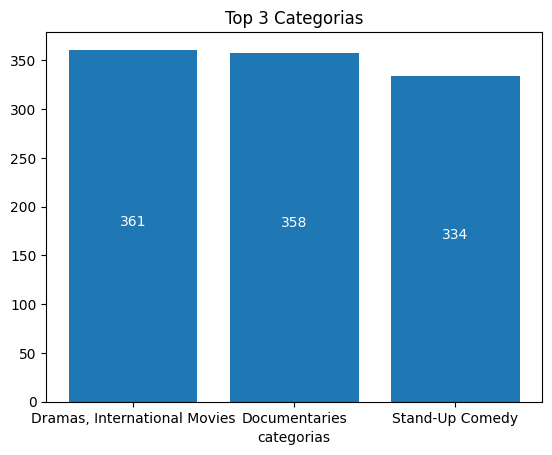

In [25]:
import matplotlib.pyplot as plt

# função para add valores nas barras 
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center', color = 'white')

plt.bar(x=top_3_categorias.categorias, height=top_3_categorias.total)
plt.xlabel('categorias')
plt.title('Top 3 Categorias')
addlabels(x=top_3_categorias.categorias, y=top_3_categorias.total)
plt.show()

In [26]:
# Top 5 Países
paises = netflix.filter('pais IS NOT NULL')
paises = paises.groupBy('pais').agg(f.count('*').alias('total')).sort(f.desc('total'))
top_paises = paises.limit(5)
top_paises.show()
top_paises = top_paises.toPandas()
top_paises

+--------------+-----+
|          pais|total|
+--------------+-----+
| United States| 2805|
|         India|  972|
|United Kingdom|  419|
|         Japan|  245|
|   South Korea|  199|
+--------------+-----+



,pais,total
0,United States,2805
1,India,972
2,United Kingdom,419
3,Japan,245
4,South Korea,199


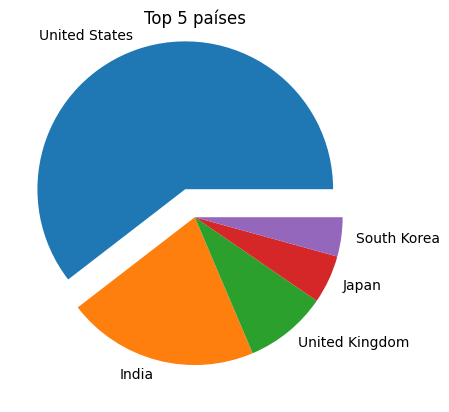

In [27]:
# plotando o gráfico de pizza

label = top_paises.pais
myexplode = [0.2, 0, 0, 0, 0]
plt.pie(top_paises.total, labels=label, explode=myexplode)
plt.title('Top 5 países')
plt.show()

In [28]:
# retirando os valores nulos do dataset

netflix_transformado = netflix.dropna(how='any')
netflix_transformado.show(5)

Py4JJavaError: An error occurred while calling o355.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 64.0 failed 1 times, most recent failure: Lost task 0.0 in stage 64.0 (TID 46) (DESKTOP-8G6K0Q3.localdomain executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:81)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 33 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:506)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:459)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:48)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3868)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2863)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:3858)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:510)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3856)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3856)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2863)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3084)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:288)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:327)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:81)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 33 more


In [ ]:
netflix_transformado.count()

Py4JJavaError: An error occurred while calling o355.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 65.0 failed 1 times, most recent failure: Lost task 0.0 in stage 65.0 (TID 47) (DESKTOP-8G6K0Q3.localdomain executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:81)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 26 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:81)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 26 more


In [ ]:
from operator import contains
from numpy.lib.function_base import select

# separando o dataset por duração (Season)

season = netflix_transformado.filter(netflix_transformado.duracao.like('%Season%'))

season.show(5)
season.count()

In [ ]:
# separando o dataset por duração (Minutos)

filmes_minutos = netflix_transformado.filter(netflix_transformado.duracao.contains('min'))
filmes_minutos.show(5)

In [ ]:
# tranformando o valor da duração em minutos (str) para int
filmes_minutos = filmes_minutos.withColumn('duracao', f.regexp_replace('duracao', ' min', ''))
filmes_minutos.show(5)

In [ ]:
filmes_minutos = filmes_minutos.withColumn('duracao', filmes_minutos['duracao'].cast(IntegerType()))
filmes_minutos.printSchema()

In [ ]:
from numpy.core.fromnumeric import mean
# Média de duração dos filmes (min)

media_duracao = filmes_minutos.select(f.mean(filmes_minutos.duracao).alias('media'))
media_duracao = media_duracao.select(f.round('media', 2))
media_duracao.show()

In [ ]:
# Verificando as estatísticas básicas do dataset filmes_minutos

filmes_minutos.select("duracao").summary().show()

In [ ]:
# boxplot - verificando outliers

filmes_minutos_plot = filmes_minutos.toPandas()

bp = plt.boxplot(x='duracao', data=filmes_minutos_plot, vert=1, patch_artist=True, labels=['Duração'])
colors = 'blue'
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
for whisker in bp['whiskers']:
    whisker.set(color ='red',
                linewidth = 1.5,
                linestyle =":")
plt.show()

In [ ]:
fim_spark_netflix = time.time()

---
### Comparando os resultados
---

In [ ]:
#Spark
t2 = fim_spark_netflix - inicio_spark_netflix
print(f'Usando Spark: {t2}')